<a href="https://colab.research.google.com/gist/Manojreddy-07/59f46cec7ba96acc79eb2620aaf9352e/air__bidirec_lstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#importing the necessary libraries and dependencies(pandas,numpy,seaborn,sklearn,tensorflow,keras,sklearn,matplotlib)
import pandas as pd
import numpy as np
import seaborn as sns;
from sklearn import preprocessing
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from numpy import array
#bidirectional LSTM
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Bidirectional
from keras.callbacks import ReduceLROnPlateau
from keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import r2_score #metrices
from statsmodels.graphics.tsaplots import plot_acf #autocorrelation

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# New Section

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/modified_data_delhi.csv")
print(df)

          No  year  month  day  hour   PM2.5    PM10    SO2    NO2     CO  \
0          1  2015      1    1     5  454.58  976.99   6.17  37.41  26.19   
1          2  2015      1    1     6  454.58  862.23   7.33  32.06  11.04   
2          3  2015      1    1     7  454.58  731.83   8.00  30.97   8.39   
3          4  2015      1    1     8  454.58  725.74   9.00  26.83   7.89   
4          5  2015      1    1     9  454.58  656.93   6.67  26.22   4.25   
...      ...   ...    ...  ...   ...     ...     ...    ...    ...    ...   
48183  48184  2020      6   30    20   43.19  123.26  10.64  22.28   0.92   
48184  48185  2020      6   30    21   45.30  125.22  10.59  22.91   1.04   
48185  48186  2020      6   30    22   49.04  129.39  10.20  20.95   1.00   
48186  48187  2020      6   30    23   50.51  128.86  10.98  20.40   0.94   
48187  48188  2020      7    1     0   54.01  128.66  11.15  21.05   0.97   

          O3   TEMP   PRES   DEWP  RAIN      wd  WSPM  
0      16.00   8.41

In [ ]:
#number of rows and columns in the dataset
print(df.shape)

(48188, 17)


In [ ]:
#checking how many null values are in each column and performing summation
df.isnull().sum()

No          0
year        0
month       0
day         0
hour        0
PM2.5     375
PM10     2418
SO2      2852
NO2       330
CO        364
O3       2201
TEMP        0
PRES        0
DEWP        0
RAIN        0
wd          0
WSPM        0
dtype: int64

Just doing `df.dropna()` drops all the NaN values only for the current execution of the cell. If you do the above `df.isnull().sum()` now, you can see that null values still persists. You can solve this by assigning the obtained output of
`df.dopna()` to the variable `df` which stores our data (dataframe)

In [ ]:
# dropping all the rows with NaN values(having no number)
df = df.dropna()
print(df.shape)#(48188, 17)initial number of rows and colmuns

(44587, 17)


In [ ]:
#defining training and testing data
x_train = df[:31210] #70% data for x_train
y_train = x_train['PM2.5']
x_test = df[31210:44587] #30% data x_test
y_test = x_test['PM2.5']
#print(y_test)

In [ ]:
print(x_train.head())#returns first 5 rows of data
print(x_train.shape)
print(y_train.head())
print(y_train)

   No  year  month  day  hour   PM2.5    PM10   SO2    NO2     CO     O3  \
0   1  2015      1    1     5  454.58  976.99  6.17  37.41  26.19  16.00   
1   2  2015      1    1     6  454.58  862.23  7.33  32.06  11.04  12.33   
2   3  2015      1    1     7  454.58  731.83  8.00  30.97   8.39  58.67   
3   4  2015      1    1     8  454.58  725.74  9.00  26.83   7.89  13.42   
4   5  2015      1    1     9  454.58  656.93  6.67  26.22   4.25  55.30   

    TEMP   PRES  DEWP  RAIN      wd  WSPM  
0   8.41  99.26 -0.89   0.0  341.24  4.76  
1   8.07  99.31 -1.13   0.0  338.96  4.61  
2   9.61  99.38 -0.08   0.0  336.68  4.32  
3  13.13  99.47 -1.18   0.0  334.49  3.23  
4  15.64  99.52 -0.95   0.0  333.63  2.04  
(31210, 17)
0    454.58
1    454.58
2    454.58
3    454.58
4    454.58
Name: PM2.5, dtype: float64
0        454.58
1        454.58
2        454.58
3        454.58
4        454.58
          ...  
34806    276.26
34807    225.68
34808    184.17
34809    159.84
34810    147.54
Nam

There are many pollutants. Let's first try to predict PM2.5 concentration values. Let the years 2015 and 2020 be the testing set. As you can see below, these 5 years account for 20% of the data (test set)
Here we r going

In [ ]:
df.loc[31210:44587].count() / df.shape[0] * 100 #30% of data x test(bottom)

No       30.004261
year     30.004261
month    30.004261
day      30.004261
hour     30.004261
PM2.5    30.004261
PM10     30.004261
SO2      30.004261
NO2      30.004261
CO       30.004261
O3       30.004261
TEMP     30.004261
PRES     30.004261
DEWP     30.004261
RAIN     30.004261
wd       30.004261
WSPM     30.004261
dtype: float64

In [ ]:
#Normalizing training data
train_norm = x_train['PM2.5']

#converted into array as all the methods available are for arrays and not lists
train_norm_arr = np.asarray(train_norm)
train_norm = np.reshape(train_norm_arr, (-1, 1))

#Scaling all values between 0 and 1 so that large values don't just dominate
scaler = MinMaxScaler(feature_range=(0, 1))
train_norm = scaler.fit_transform(train_norm)
for i in range(5):
    print(train_norm[i])

[0.51141949]
[0.51141949]
[0.51141949]
[0.51141949]
[0.51141949]


Even after normalization and scaing, null values are possible (many people disregard this). Let's check if any null values are present.

In [ ]:
count = 0
for i in range(len(train_norm)):
    if train_norm[i] == 0:
        count = count +1
print('Number of null values in train_norm = ', count)

Number of null values in train_norm =  1


In [ ]:
#removing null values
train_norm = train_norm[train_norm!=0]

In [ ]:
#Normalizing testing data and repeating the same process as done for training data
test_norm = x_test['PM2.5']
test_norm_arr = np.asarray(test_norm)
test_norm = np.reshape(test_norm_arr, (-1, 1))
scaler = MinMaxScaler(feature_range=(0, 1))
test_norm = scaler.fit_transform(test_norm)
for i in range(5):
    print(test_norm[i])

[0.15754158]
[0.15711328]
[0.17049754]
[0.21908535]
[0.30325743]


In [ ]:
count = 0
for i in range(len(test_norm)):
    if test_norm[i] == 0:
        count = count + 1
print('Number of null values in test_norm = ', count)

Number of null values in test_norm =  1


In [ ]:
#removing null values
test_norm = test_norm[test_norm != 0]

In [ ]:
print(train_norm.shape)#return number of rows and columns from given data
print(test_norm.shape)

(31209,)
(13376,)


Since this is a time series data, we should be predicting the values after looking at a set of values rather than just a single value like we usually do. This takes into account the correlation between the data points and the timestamps. Because the neighbours should be considered for how the values change over time. Let's define a function to do this.

The below function called split_sequence splits the sequence into sets of n values. This n is given as n_steps (step_size). For example, if n=3, we split the sequence in groups of 3. We create 2 empty lists and append the split sequences.

In [ ]:
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > len(sequence)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return array(X),array(y)

Here the number of features = 1 as we will be predicting a single value. Let's reshape the split sequences into the format of number of rows, number of columns. (shape[0], shape[1]). In the output, we can see that groups of 3 since n_steps = 3 have been obtained.

In [ ]:
n_steps = 3
X_split_train, y_split_train = split_sequence(train_norm, n_steps)
#for i in range(len(X_split_train)):
    #print(X_split_train[i], y_split_train[i])
n_features = 1
X_split_train = X_split_train.reshape((X_split_train.shape[0], X_split_train.shape[1], n_features))
for i in range(5):
    print(X_split_train)

[[[0.51141949]
  [0.51141949]
  [0.51141949]]

 [[0.51141949]
  [0.51141949]
  [0.51141949]]

 [[0.51141949]
  [0.51141949]
  [0.51141949]]

 ...

 [[0.32219199]
  [0.30758327]
  [0.24976567]]

 [[0.30758327]
  [0.24976567]
  [0.2023159 ]]

 [[0.24976567]
  [0.2023159 ]
  [0.17450447]]]
[[[0.51141949]
  [0.51141949]
  [0.51141949]]

 [[0.51141949]
  [0.51141949]
  [0.51141949]]

 [[0.51141949]
  [0.51141949]
  [0.51141949]]

 ...

 [[0.32219199]
  [0.30758327]
  [0.24976567]]

 [[0.30758327]
  [0.24976567]
  [0.2023159 ]]

 [[0.24976567]
  [0.2023159 ]
  [0.17450447]]]
[[[0.51141949]
  [0.51141949]
  [0.51141949]]

 [[0.51141949]
  [0.51141949]
  [0.51141949]]

 [[0.51141949]
  [0.51141949]
  [0.51141949]]

 ...

 [[0.32219199]
  [0.30758327]
  [0.24976567]]

 [[0.30758327]
  [0.24976567]
  [0.2023159 ]]

 [[0.24976567]
  [0.2023159 ]
  [0.17450447]]]
[[[0.51141949]
  [0.51141949]
  [0.51141949]]

 [[0.51141949]
  [0.51141949]
  [0.51141949]]

 [[0.51141949]
  [0.51141949]
  [0.5114194

You can see below that, we predict the value for the first 3 values, then consider that output as one of the 3 values in the next set. For example, we preedict 0.1 first, then we take that 0.1 as input in the second set and so on.

In [ ]:
X_split_test, y_split_test = split_sequence(test_norm, n_steps)
for i in range(5):
    print(X_split_test[i], y_split_test[i])
n_features = 1
X_split_test = X_split_test.reshape((X_split_test.shape[0], X_split_test.shape[1], n_features))

[0.15754158 0.15711328 0.17049754] 0.21908534989411568
[0.15711328 0.17049754 0.21908535] 0.3032574297475432
[0.17049754 0.21908535 0.30325743] 0.41904014086182684
[0.21908535 0.30325743 0.41904014] 0.44580864682228083
[0.30325743 0.41904014 0.44580865] 0.46179836771599203


Let's define our neural network (LSTM: Long Short Term Memory). Let's add 50 nodes in our first layer with a ReLU (Rectified linear unit) activation. Their shape will be step size, number of features. Then we will add, a dense layer with one node for the output.

We can try out different optimizers to see which minimizes loss and maximizes accuracy. Stochastic gradient descent (SGD), Adam, AdaBoost, RMSProp are few of them. lr = learning rate, decay = by how much to decay the learning rate, momentum = how much should the gradient descent be accelerated to dampen oscillations, nesterov = whether to use nesterov momentum. Nesterov has stronger convergence for convex functions. And then we compile using MSE (mean squared loss) as our loss function.

In [ ]:
# Define model
model = Sequential()
model.add(Bidirectional(LSTM(128, activation='relu', input_shape=(n_steps, n_features), return_sequences=True)))
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(64, activation='relu')))
model.add(Dropout(0.2))
model.add(Dense(1))

# Define optimizer
adam = Adam(lr=0.001, decay=1e-6)

# Compile model
model.compile(optimizer=adam, loss='mse', metrics=['mae', 'accuracy'])

# Add learning rate reduction callback
lr_reducer = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)

/usr/local/lib/python3.9/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [ ]:
# Fit model
hist = model.fit(X_split_train, y_split_train, validation_data=(X_split_test, y_split_test), epochs=50, batch_size=64, callbacks=[lr_reducer], verbose=1)

Epoch 1/50
488/488 [==============================] - 24s 38ms/step - loss: 0.0027 - mae: 0.0309 - accuracy: 3.2045e-05 - val_loss: 6.1478e-04 - val_mae: 0.0158 - val_accuracy: 7.4778e-05 - lr: 0.0010
Epoch 2/50
488/488 [==============================] - 18s 37ms/step - loss: 0.0017 - mae: 0.0242 - accuracy: 3.2045e-05 - val_loss: 4.7488e-04 - val_mae: 0.0142 - val_accuracy: 7.4778e-05 - lr: 0.0010
Epoch 3/50
488/488 [==============================] - 17s 35ms/step - loss: 0.0016 - mae: 0.0235 - accuracy: 3.2045e-05 - val_loss: 5.0239e-04 - val_mae: 0.0163 - val_accuracy: 7.4778e-05 - lr: 0.0010
Epoch 4/50
488/488 [==============================] - 17s 34ms/step - loss: 0.0016 - mae: 0.0226 - accuracy: 3.2045e-05 - val_loss: 3.8711e-04 - val_mae: 0.0133 - val_accuracy: 7.4778e-05 - lr: 0.0010
Epoch 5/50
488/488 [==============================] - ETA: 0s - loss: 0.0015 - mae: 0.0221 - accuracy: 3.2045e-05
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
488/48

In [ ]:
# fit model
#hist = model.fit(X_split_train, y_split_train, validation_data=(X_split_test, y_split_test), epochs=10, verbose = 1)

In [ ]:
print(hist.history.keys())

NameError: ignored

In [ ]:
yhat = model.predict(X_split_test)

NameError: ignored

In [ ]:
import xgboost as xgb

In [ ]:

# Get predictions from the LSTM model on the test data
yhat = model.predict(X_split_test)

# Reshape yhat to match the shape of X_split_test
yhat_reshaped = np.reshape(yhat, (yhat.shape[0], 1, yhat.shape[1]))
yhat_reshaped = np.repeat(yhat_reshaped, n_steps, axis=1)

# Reshape X_split_test to match the shape of yhat
X_test_reshaped = np.reshape(X_split_test, (X_split_test.shape[0], X_split_test.shape[1], 1))

# Combine the LSTM predictions with other features in your test data
X_test_combined = np.concatenate([X_test_reshaped, yhat_reshaped], axis=2)

# Train an XGBoosting tree model on the combined data
xgb_model = xgb.XGBRegressor()
xgb_model.fit(np.reshape(X_test_combined, (X_test_combined.shape[0], -1)), np.reshape(y_split_test, (y_split_test.shape[0],)))

# Make final predictions using the Integrated dual model
y_pred_combined = np.concatenate([X_test_reshaped, yhat_reshaped], axis=2)
y_pred_final = xgb_model.predict(np.reshape(y_pred_combined, (y_pred_combined.shape[0], -1)))

418/418 [==============================] - 3s 7ms/step


In [ ]:
#y_split_test, yhat
# calculate MSE and RMSE
mse = mean_squared_error(y_split_test, y_pred_final)
rmse = np.sqrt(mse)
print('MSE: %.5f' % mse)
print('RMSE: %.5f' % rmse)

# calculate MAE
mae = mean_absolute_error(y_split_test, y_pred_final)
print('MAE: %.5f' % mae)

# calculate MAPE
mape = np.mean(np.abs((y_split_test - y_pred_final) / y_split_test)) * 100
print('MAPE: %.5f%%' % mape)

# calculate R-squared
r2 = r2_score(y_split_test, y_pred_final)
print('R-squared: %.5f' % r2)

# calculate IA
ia = 1 - np.sum(np.abs(np.array(y_pred_final) - np.array(y_split_test))) / np.sum(y_split_test)
print('IA: %.5f' % ia)

MSE: 0.00005
RMSE: 0.00739
MAE: 0.00525
MAPE: 8.54472%
R-squared: 0.99551
IA: 0.95384


Below, I have plotted the actual true values (first plot) and preedicted values (second plot). One can visually see that the distribution is almost the same. This says that our predictions are very accurate.

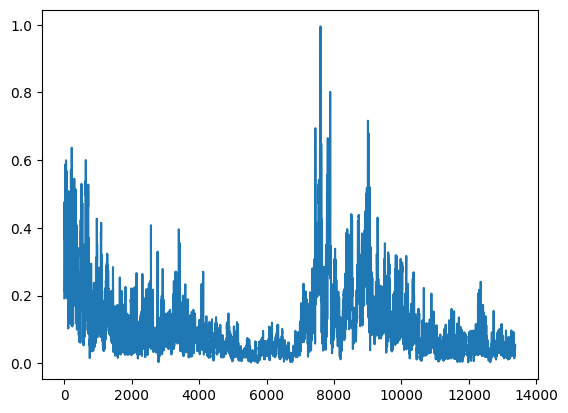

In [ ]:
plt.plot(y_pred_final)

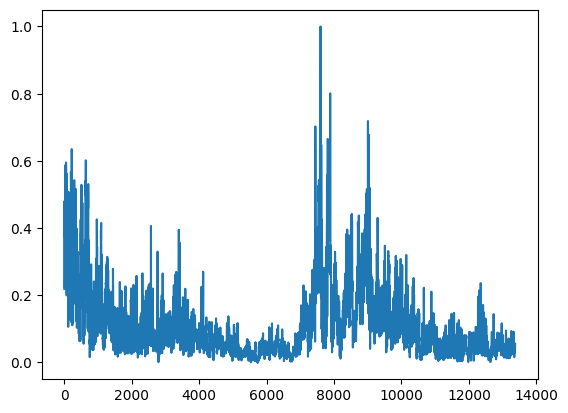

In [ ]:
plt.plot(y_split_test)

In [ ]:
train_acc = model.evaluate(X_split_train, y_split_train, verbose=0)[1]
test_acc = model.evaluate(X_split_test, y_split_test, verbose=0)[1]
print('Train: %.5f, Test: %.5f' % (train_acc, test_acc))

Train: 0.01825, Test: 0.01035


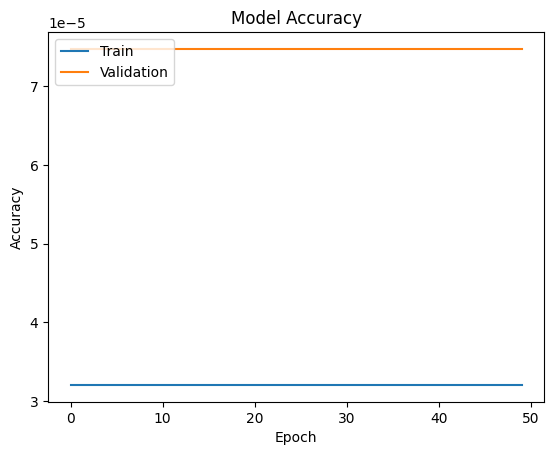

In [ ]:
# Plot training and validation accuracy
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

Above, accuracy increase a lot in the last few epochs. Below, the loss gradually decrease. These are positive signs that our model is doing very good.

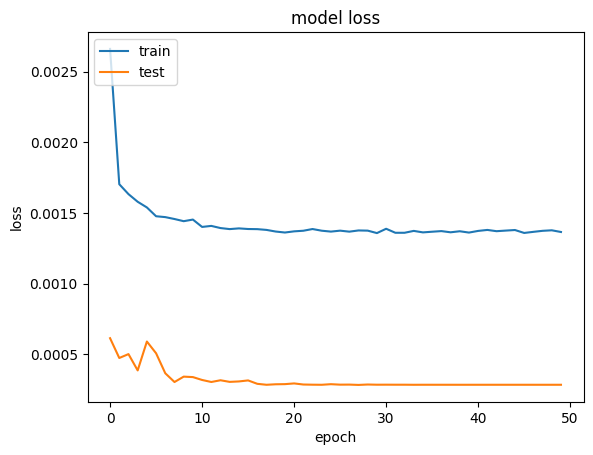

In [ ]:
# summarize history for loss
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Until now, we just ran our model for prediction of a single pollutant. We have 6 pollutants in our dataset and can make predictions for all of them. So, I have made a function which can be used to predict the other pollutants rather than having to write the code again and again. I have commented the function calls. You can fork this kernel to uncomment and predit the other pollutants (Coz it would take up a lot of space and time).

In [ ]:
def compute(var):
    train_norm = x_train[var]
    train_norm_arr = np.asarray(train_norm)
    train_norm = np.reshape(train_norm_arr, (-1, 1))
    scaler = MinMaxScaler(feature_range=(0, 1))
    train_norm = scaler.fit_transform(train_norm)
    train_norm = train_norm[train_norm != 0]

    test_norm = x_test[var]
    test_norm_arr = np.asarray(test_norm)
    test_norm = np.reshape(test_norm_arr, (-1, 1))
    scaler = MinMaxScaler(feature_range=(0, 1))
    test_norm = scaler.fit_transform(test_norm)
    test_norm = test_norm[test_norm != 0]

    X_split_train, y_split_train = split_sequence(train_norm, n_steps)
    X_split_train = X_split_train.reshape((X_split_train.shape[0], X_split_train.shape[1], n_features))

    X_split_test, y_split_test = split_sequence(test_norm, n_steps)
    X_split_test = X_split_test.reshape((X_split_test.shape[0], X_split_test.shape[1], n_features))

    # Fit model
    hist = model.fit(X_split_train, y_split_train, validation_data=(X_split_test, y_split_test), epochs=50, batch_size=64, callbacks=[lr_reducer], verbose=1)


    # Get predictions from the LSTM model on the test data
    yhat = model.predict(X_split_test)

    # Reshape yhat to match the shape of X_split_test
    yhat_reshaped = np.reshape(yhat, (yhat.shape[0], 1, yhat.shape[1]))
    yhat_reshaped = np.repeat(yhat_reshaped, n_steps, axis=1)

    # Reshape X_split_test to match the shape of yhat
    X_test_reshaped = np.reshape(X_split_test, (X_split_test.shape[0], X_split_test.shape[1], 1))

    # Combine the LSTM predictions with other features in your test data
    X_test_combined = np.concatenate([X_test_reshaped, yhat_reshaped], axis=2)

    # Train an XGBoosting tree model on the combined data
    xgb_model = xgb.XGBRegressor()
    xgb_model.fit(np.reshape(X_test_combined, (X_test_combined.shape[0], -1)), np.reshape(y_split_test, (y_split_test.shape[0],)))

    # Make final predictions using the Integrated dual model
    y_pred_combined = np.concatenate([X_test_reshaped, yhat_reshaped], axis=2)
    y_pred_final = xgb_model.predict(np.reshape(y_pred_combined, (y_pred_combined.shape[0], -1)))

    #y_split_test, yhat
    # calculate MSE and RMSE
    mse = mean_squared_error(y_split_test, y_pred_final)
    rmse = np.sqrt(mse)
    print('MSE: %.5f' % mse)
    print('RMSE: %.5f' % rmse)

    # calculate MAE
    mae = mean_absolute_error(y_split_test, y_pred_final)
    print('MAE: %.5f' % mae)

    # calculate MAPE
    mape = np.mean(np.abs((y_split_test - y_pred_final) / y_split_test)) * 100
    print('MAPE: %.5f%%' % mape)

    # calculate R-squared
    r2 = r2_score(y_split_test, y_pred_final)
    print('R-squared: %.5f' % r2)

    # calculate IA
    ia = 1 - np.sum(np.abs(np.array(yhat) - np.array(y_split_test))) / np.sum(y_split_test)
    print('IA: %.5f' % ia)

    train_acc = model.evaluate(X_split_train, y_split_train, verbose=0)[1]
    test_acc = model.evaluate(X_split_test, y_split_test, verbose=0)[1]
    print('Train: %.5f, Test: %.5f' % (train_acc, test_acc))

    plt.plot(hist.history['accuracy'])
    plt.plot(hist.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

    plt.plot(hist.history['loss'])
    plt.plot(hist.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

Epoch 1/50
488/488 [==============================] - 17s 35ms/step - loss: 0.0029 - mae: 0.0344 - accuracy: 3.2045e-05 - val_loss: 6.8758e-04 - val_mae: 0.0155 - val_accuracy: 1.4956e-04 - lr: 6.1035e-08
Epoch 2/50
488/488 [==============================] - 17s 35ms/step - loss: 0.0029 - mae: 0.0344 - accuracy: 3.2045e-05 - val_loss: 6.8594e-04 - val_mae: 0.0155 - val_accuracy: 1.4956e-04 - lr: 6.1035e-08
Epoch 3/50
488/488 [==============================] - 17s 35ms/step - loss: 0.0029 - mae: 0.0344 - accuracy: 3.2045e-05 - val_loss: 6.8490e-04 - val_mae: 0.0156 - val_accuracy: 1.4956e-04 - lr: 6.1035e-08
Epoch 4/50
487/488 [============================>.] - ETA: 0s - loss: 0.0029 - mae: 0.0344 - accuracy: 3.2084e-05
Epoch 4: ReduceLROnPlateau reducing learning rate to 3.051757957450718e-08.
488/488 [==============================] - 17s 34ms/step - loss: 0.0029 - mae: 0.0344 - accuracy: 3.2045e-05 - val_loss: 6.8418e-04 - val_mae: 0.0156 - val_accuracy: 1.4956e-04 - lr: 6.1035e-08
E

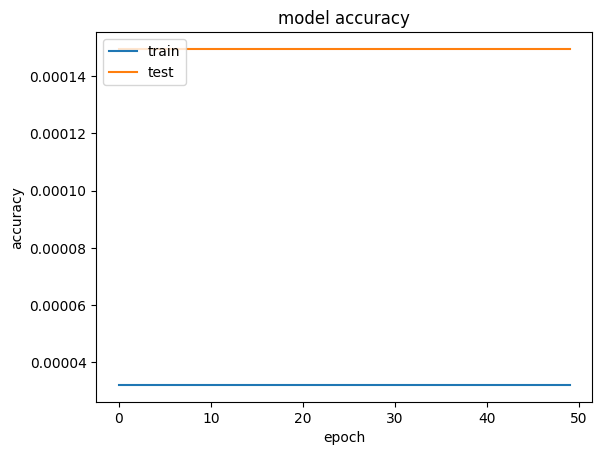

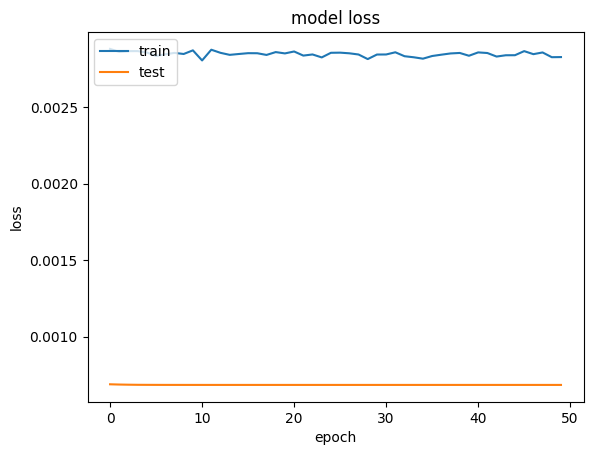

In [ ]:
compute('PM10')

Epoch 1/50
488/488 [==============================] - 11s 22ms/step - loss: 0.0010 - mae: 0.0184 - accuracy: 0.0000e+00 - val_loss: 8.3322e-04 - val_mae: 0.0172 - val_accuracy: 7.4778e-05 - lr: 3.0518e-08
Epoch 2/50
488/488 [==============================] - 10s 20ms/step - loss: 0.0010 - mae: 0.0183 - accuracy: 3.2045e-05 - val_loss: 8.3332e-04 - val_mae: 0.0172 - val_accuracy: 7.4778e-05 - lr: 3.0518e-08
Epoch 3/50
488/488 [==============================] - 9s 18ms/step - loss: 0.0010 - mae: 0.0182 - accuracy: 3.2045e-05 - val_loss: 8.3343e-04 - val_mae: 0.0172 - val_accuracy: 7.4778e-05 - lr: 3.0518e-08
Epoch 4/50
488/488 [==============================] - ETA: 0s - loss: 0.0010 - mae: 0.0183 - accuracy: 0.0000e+00
Epoch 4: ReduceLROnPlateau reducing learning rate to 1.525878978725359e-08.
488/488 [==============================] - 11s 22ms/step - loss: 0.0010 - mae: 0.0183 - accuracy: 0.0000e+00 - val_loss: 8.3354e-04 - val_mae: 0.0172 - val_accuracy: 7.4778e-05 - lr: 3.0518e-08
Ep

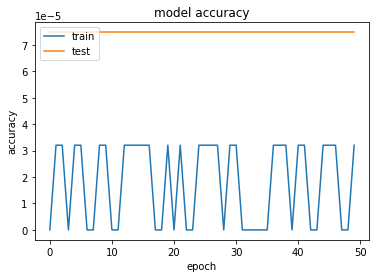

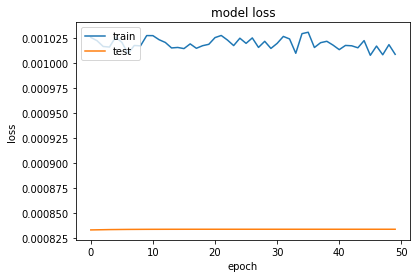

In [ ]:
compute('SO2')

Epoch 1/50
488/488 [==============================] - 12s 25ms/step - loss: 0.0015 - mae: 0.0247 - accuracy: 3.2047e-05 - val_loss: 0.0011 - val_mae: 0.0201 - val_accuracy: 7.4778e-05 - lr: 9.3132e-13
Epoch 2/50
488/488 [==============================] - 12s 25ms/step - loss: 0.0015 - mae: 0.0248 - accuracy: 3.2047e-05 - val_loss: 0.0011 - val_mae: 0.0201 - val_accuracy: 7.4778e-05 - lr: 9.3132e-13
Epoch 3/50
488/488 [==============================] - 13s 27ms/step - loss: 0.0015 - mae: 0.0249 - accuracy: 3.2047e-05 - val_loss: 0.0011 - val_mae: 0.0201 - val_accuracy: 7.4778e-05 - lr: 9.3132e-13
Epoch 4/50
488/488 [==============================] - ETA: 0s - loss: 0.0014 - mae: 0.0248 - accuracy: 0.0000e+00
Epoch 4: ReduceLROnPlateau reducing learning rate to 4.656613094254636e-13.
488/488 [==============================] - 12s 24ms/step - loss: 0.0014 - mae: 0.0248 - accuracy: 0.0000e+00 - val_loss: 0.0011 - val_mae: 0.0201 - val_accuracy: 7.4778e-05 - lr: 9.3132e-13
Epoch 5/50
488/48

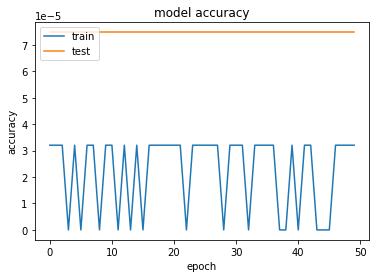

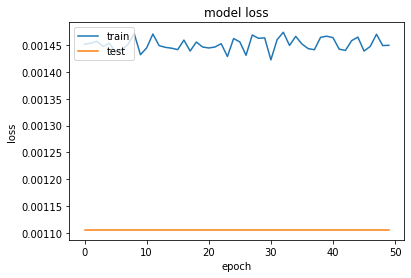

In [ ]:
compute('NO2')

Epoch 1/10
970/970 [==============================] - 5s 6ms/step - loss: 0.0010 - accuracy: 3.2246e-05 - val_loss: 0.0033 - val_accuracy: 7.4778e-05
Epoch 2/10
970/970 [==============================] - 5s 5ms/step - loss: 9.8963e-04 - accuracy: 3.2246e-05 - val_loss: 0.0029 - val_accuracy: 7.4778e-05
Epoch 3/10
970/970 [==============================] - 6s 6ms/step - loss: 9.7783e-04 - accuracy: 3.2246e-05 - val_loss: 0.0028 - val_accuracy: 7.4778e-05
Epoch 4/10
970/970 [==============================] - 5s 5ms/step - loss: 9.7536e-04 - accuracy: 3.2246e-05 - val_loss: 0.0024 - val_accuracy: 7.4778e-05
Epoch 5/10
970/970 [==============================] - 4s 4ms/step - loss: 9.6936e-04 - accuracy: 3.2246e-05 - val_loss: 0.0022 - val_accuracy: 7.4778e-05
Epoch 6/10
970/970 [==============================] - 6s 7ms/step - loss: 9.6879e-04 - accuracy: 3.2246e-05 - val_loss: 0.0027 - val_accuracy: 7.4778e-05
Epoch 7/10
970/970 [==============================] - 5s 5ms/step - loss: 9.6604

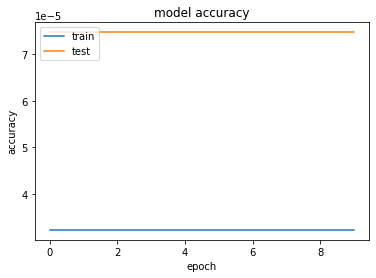

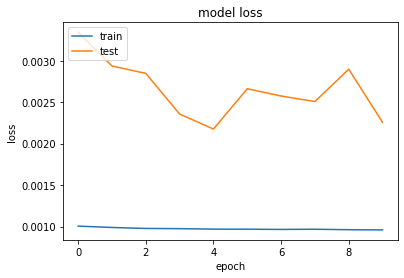

In [ ]:
compute('CO')

Epoch 1/10
976/976 [==============================] - 5s 5ms/step - loss: 9.4624e-04 - accuracy: 3.2045e-05 - val_loss: 0.0054 - val_accuracy: 7.4778e-05
Epoch 2/10
976/976 [==============================] - 6s 6ms/step - loss: 9.1051e-04 - accuracy: 3.2045e-05 - val_loss: 0.0045 - val_accuracy: 7.4778e-05
Epoch 3/10
976/976 [==============================] - 5s 5ms/step - loss: 9.0447e-04 - accuracy: 3.2045e-05 - val_loss: 0.0046 - val_accuracy: 7.4778e-05
Epoch 4/10
976/976 [==============================] - 5s 5ms/step - loss: 9.0123e-04 - accuracy: 3.2045e-05 - val_loss: 0.0064 - val_accuracy: 7.4778e-05
Epoch 5/10
976/976 [==============================] - 5s 5ms/step - loss: 9.0064e-04 - accuracy: 3.2045e-05 - val_loss: 0.0044 - val_accuracy: 7.4778e-05
Epoch 6/10
976/976 [==============================] - 5s 5ms/step - loss: 8.9460e-04 - accuracy: 3.2045e-05 - val_loss: 0.0051 - val_accuracy: 7.4778e-05
Epoch 7/10
976/976 [==============================] - 6s 6ms/step - loss: 8.

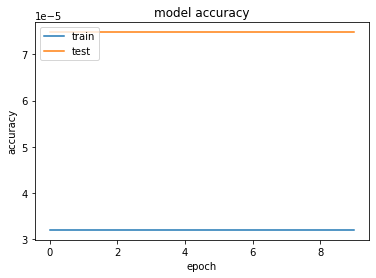

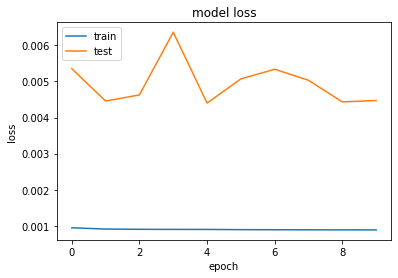

In [ ]:
compute('O3')

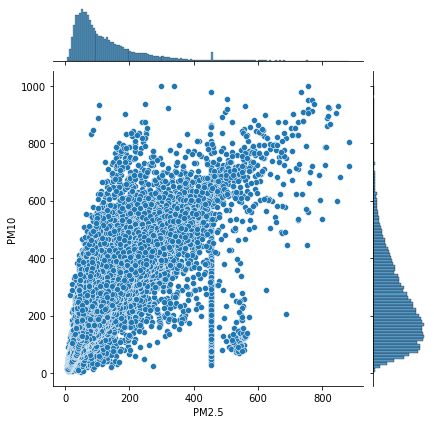

In [ ]:
sns.jointplot(x=df['PM2.5'], y=df['PM10'], data = df)

The above plot gives us the idea that these two conentrations are positively correlated with very few outliers.

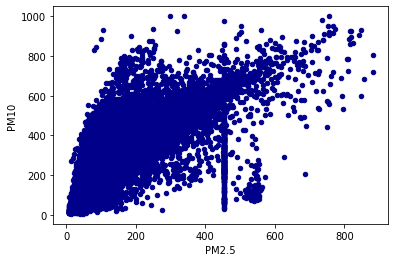

In [ ]:
df.plot.scatter(x='PM2.5', y='PM10', c='DarkBlue')

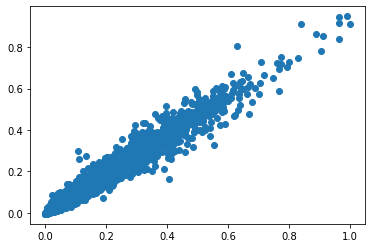

In [ ]:
plt.scatter(y_split_test, yhat)

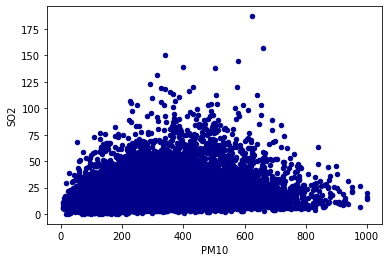

In [ ]:
df.plot.scatter(x='PM10', y='SO2', c='DarkBlue')

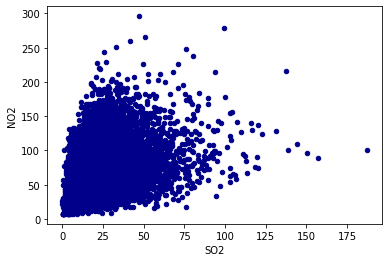

In [ ]:
df.plot.scatter(x='SO2', y='NO2', c='DarkBlue')

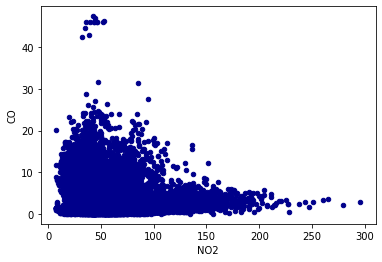

In [ ]:
df.plot.scatter(x='NO2', y='CO', c='DarkBlue')

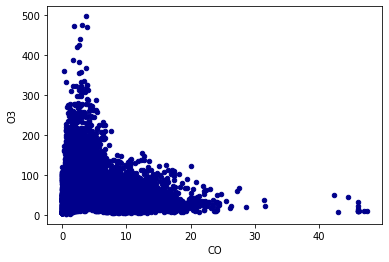

In [ ]:
df.plot.scatter(x='CO', y='O3', c='DarkBlue')

Heatmap is a very useful visualization tool to know how much each feature is correlated. vmax = max value of the heatmap fmt = number of decimal places upto which the value is shown square = do you want the heatmap to be square shaped linewidth = width of the lines in the heatmap annot = should the boxes be labelled with the value.

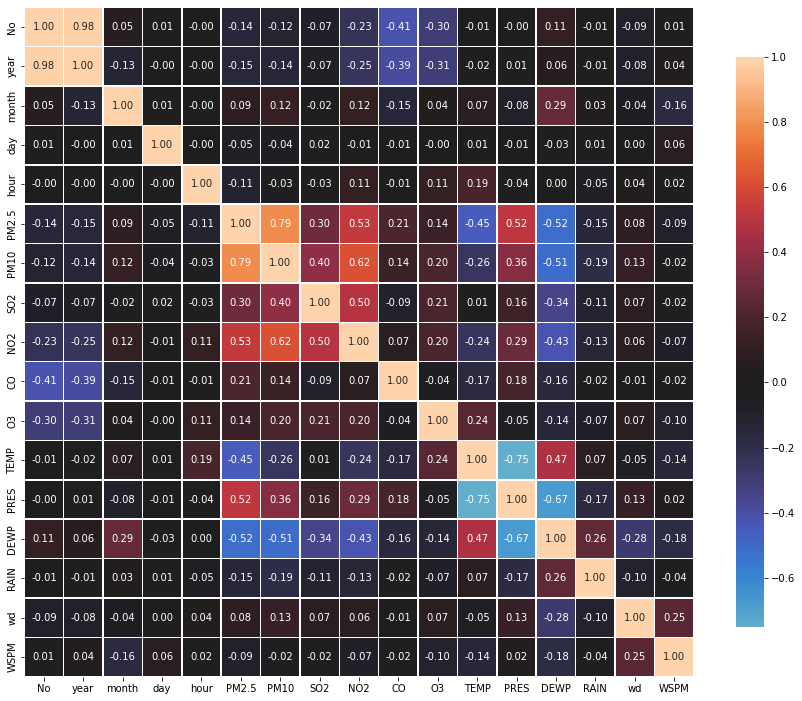

In [ ]:
correlations = df.corr()
fig, ax = plt.subplots(figsize=(15,15))
sns.heatmap(correlations, vmax=1.0, center=0, fmt='.2f', square=True, linewidths=.5, annot=True, cbar_kws={"shrink": .70})
plt.show();